In [7]:


import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split

DATASET_PATH = '/Users/mayuri/Neuromorphic Project/SoundClassificationProject/SoundClassification/kitchen_spike_dataset/sample_info.npy'
BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:

class RandomChannelDropout:
    def __init__(self, probability=0.5, max_channels_to_drop=4):
        self.p = probability
        self.n = max_channels_to_drop

    def __call__(self, spikes):
        # spikes shape: [Time, Channels]
        if np.random.rand() < self.p:
            # Pick random channels to drop
            num_drop = np.random.randint(1, self.n + 1)
            channels_to_drop = np.random.choice(spikes.shape[1], num_drop, replace=False)
            
            # Create a copy to avoid modifying original dataset
            spikes = spikes.copy()
            spikes[:, channels_to_drop] = 0.0
        return spikes
    
class AddGaussianNoise:
    def __init__(self, mean=0., std=0.1):
        self.std = std
        self.mean = mean
        
    def __call__(self, spikes):
        noise = np.random.normal(self.mean, self.std, spikes.shape)
        return spikes + noise

In [9]:

class SpikeRasterDataset(Dataset):
    def __init__(self, sample_info_path, transform=None):
        self.sample_info = np.load(sample_info_path, allow_pickle=True)
        self.transform = transform
        
        self.old_root = '/content/drive/MyDrive/D7046E_SNN_project_dataset/kitchen_spike_dataset'
        self.new_root = os.path.dirname(sample_info_path)

    def __len__(self):
        return len(self.sample_info)

    def __getitem__(self, idx):
        old_path, class_idx = self.sample_info[idx]
        current_path = str(old_path).replace(self.old_root, self.new_root).replace('\\', '/')
        
        try:
            spikes = np.load(current_path)
        except FileNotFoundError:
            raise FileNotFoundError(f"File not found: {current_path}")

        # Apply Augmentation
        if self.transform is not None:
            spikes = self.transform(spikes)
            
        return torch.from_numpy(spikes).float(), class_idx

In [10]:

if os.path.exists(DATASET_PATH):
    train_transform = RandomChannelDropout(probability=0.4)
    
    full_dataset = SpikeRasterDataset(DATASET_PATH, transform=None)
    
    # Split
    total_len = len(full_dataset)
    train_len = int(0.7 * total_len)
    val_len = int(0.15 * total_len)
    test_len = total_len - train_len - val_len
    
    train_set_base, val_set, test_set = random_split(full_dataset, [train_len, val_len, test_len])
    
    # Wrap train set to add transform dynamically
    class TransformedSubset(torch.utils.data.Dataset):
        def __init__(self, subset, transform=None):
            self.subset = subset
            self.transform = transform
        def __getitem__(self, index):
            x, y = self.subset[index]
            if self.transform:
                # subset returns tensor, convert to numpy for our transform, then back
                x = self.transform(x.numpy())
                x = torch.from_numpy(x).float()
            return x, y
        def __len__(self):
            return len(self.subset)

    train_set_aug = TransformedSubset(train_set_base, transform=train_transform)

    # Dataloaders
    train_dl = DataLoader(train_set_aug, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
    test_dl = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)
    
    print(f"Train: {len(train_set_aug)} (with Augmentation), Val: {len(val_set)}, Test: {len(test_set)}")
else:
    print("Dataset path not found.")

Train: 1031 (with Augmentation), Val: 220, Test: 222


In [11]:

import torch.nn as nn
import torch.optim as optim
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

# Rockpool
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential, Residual

# HierarchicalMultiTauSNN
class HierarchicalMultiTauSNN(nn.Module):
   
    def __init__(self, in_ch=16, hidden_1=128, hidden_2=256, out_ch=24, dt=1e-2):
        super().__init__()
        
        # layer 1: fast dynamics
        self.layer1_enc = LinearTorch((in_ch, hidden_1), has_bias=False)
        self.layer1_bn = nn.BatchNorm1d(hidden_1) 
        self.layer1_lif = LIFTorch(
            shape=(hidden_1,), 
            tau_mem=torch.tensor([0.02]), # 20ms
            tau_syn=torch.tensor([0.02]), 
            dt=dt
        )
        
        # layer 2: slow dynamics 
        self.layer2_enc = LinearTorch((hidden_1, hidden_2), has_bias=False)
        self.layer2_rec = Residual(LinearTorch((hidden_2, hidden_2), has_bias=False))
        self.layer2_bn = nn.BatchNorm1d(hidden_2)
        self.layer2_lif = LIFTorch(
            shape=(hidden_2,), 
            tau_mem=torch.tensor([0.2]), # 200ms (10x slower)
            tau_syn=torch.tensor([0.2]), 
            dt=dt
        )
        
        # readout
        self.readout = LinearTorch((hidden_2, out_ch), has_bias=False)
        self.output_lif = LIFTorch(
            shape=(out_ch,), 
            tau_mem=torch.tensor([0.2]), 
            tau_syn=torch.tensor([0.2]), 
            dt=dt
        )
        
    
        for m in self.layer2_rec.children():
            if isinstance(m, LinearTorch):
                nn.init.orthogonal_(m.weight)

    def forward(self, x):
        # x: [Batch, Time, Channels]
        
        # Block 1 (Fast Feedforward)
        out, _, _ = self.layer1_enc(x)
        out = self.layer1_bn(out.permute(0,2,1)).permute(0,2,1)
        spikes_1, _, _ = self.layer1_lif(out)
        
        #  Block 2 (Slow Recurrent)
        out, _, _ = self.layer2_enc(spikes_1)
        out, _, _ = self.layer2_rec(out)
        out = self.layer2_bn(out.permute(0,2,1)).permute(0,2,1)
        spikes_2, _, _ = self.layer2_lif(out)
        
        # Block 3 (Output)
        out, _, _ = self.readout(spikes_2)
        spikes_out, _, _ = self.output_lif(out)
        
        return spikes_out, spikes_2, spikes_1

# Initialize
net = HierarchicalMultiTauSNN(dt=1e-2).to(DEVICE)
print("Hierarchical Model Initialized.")

Hierarchical Model Initialized.


In [12]:
# training setup
loss_fun = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-4)

# Scheduler to drop LR when stuck
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4, factor=0.5)

num_epochs = 50
accuracy = []
loss_t = []

# training loop
with tqdm(range(num_epochs), unit='Epoch', desc='Training') as pbar:
    for epoch in pbar:
        correct = 0
        total = 0
        running_loss = 0
        
        net.train()

        for events, labels in train_dl:
            events = events.to(DEVICE)
            arr = np.array(labels, dtype=np.long)
            labels = torch.tensor(arr, dtype=torch.long).to(DEVICE)
            
            optimizer.zero_grad()

            # Forward pass
            output, _, _ = net(events)

            # Add small epsilon to avoid dead neurons causing NaN
            summed_output = torch.sum(output, dim=1) + 1e-8

            loss = loss_fun(summed_output, labels)
            
            # Regularization: Small penalty for high firing rates (Energy Efficiency)
            # loss += 0.001 * torch.mean(output) 

            loss.backward()
            
            # Clip Gradients
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            
            optimizer.step()

            # Metrics
            predicted = torch.argmax(summed_output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

        epoch_acc = (correct / total) * 100
        epoch_loss = running_loss / len(train_dl)
        
        accuracy.append(epoch_acc)
        loss_t.append(epoch_loss)
        
        # Update Scheduler
        scheduler.step(epoch_loss)
        
        pbar.set_postfix(Loss=f'{epoch_loss:.2f}', Acc=f'{epoch_acc:.1f}%')

print(f"Final Training Accuracy: {accuracy[-1]:.3f}%")

Training:   0%|          | 0/50 [00:00<?, ?Epoch/s]

Final Training Accuracy: 3.298%


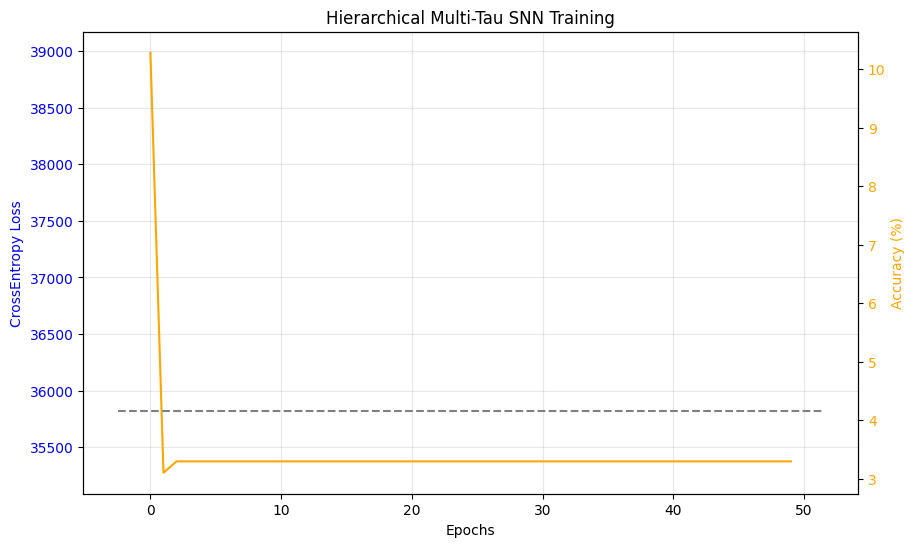

TEST ACCURACY: 3.60%


In [13]:

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(loss_t, color='blue', label='Loss')
ax.set_ylabel('CrossEntropy Loss', color='blue')
ax.set_xlabel('Epochs')
ax.tick_params(axis='y', labelcolor='blue')
ax.grid(True, alpha=0.3)

ax2 = ax.twinx()
ax2.plot(accuracy, color='orange', label='Accuracy')
ax2.plot(ax2.get_xlim(), [100/24, 100/24], '--', color='gray', label='Chance')
ax2.set_ylabel('Accuracy (%)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Hierarchical Multi-Tau SNN Training')
plt.show()

# Test evaluation
net.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for events, labels in test_dl:
        events = events.to(DEVICE)
        arr = np.array(labels, dtype=np.int64)
        labels = torch.tensor(arr, dtype=torch.long).to(DEVICE)
        
        output, _, _ = net(events)
        summed_output = torch.sum(output, dim=1)
        
        predicted = torch.argmax(summed_output, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print(f"TEST ACCURACY: {(test_correct/test_total)*100:.2f}%")
